1.1 Fundamental - Word2Vec (Skipgram)
->https://www.youtube.com/watch?v=KwjrTVaQKjA&list=PLqL-7eLmqd9V3faivSAST76YQClS44dSz

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
np.__version__ , torch.__version__

('2.0.2', '2.9.0+cpu')

#1. Load Data

In [3]:
corpus = ["apple banana fruit", "banana apple fruit","banana fruit apple",
          "dog cat animal","cat animal dog","cat dog animal"]

In [4]:
#1. Tokenization
corpus = [sent.split(" ") for sent in corpus]
corpus

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'animal', 'dog'],
 ['cat', 'dog', 'animal']]

In [8]:
#2. Numeralization
#Procurar palavras únicas
flatten = lambda l: [item for sublist in l for item in sublist]
#Atribuir inteiros únicos
vocabs = list(set(flatten(corpus)))
vocabs

['dog', 'cat', 'apple', 'animal', 'fruit', 'banana']

In [9]:
#criar um mapeamente entre a palavra e o inteiro

word2index = {v:idx for idx, v in enumerate(vocabs)}

In [10]:
word2index['dog']

0

In [11]:
word2index['cat']

1

In [12]:
word2index["animal"]

3

In [13]:
vocabs.append('<UNK>')
word2index['<UNK>'] = 6

In [16]:
word2index

{'dog': 0,
 'cat': 1,
 'apple': 2,
 'animal': 3,
 'fruit': 4,
 'banana': 5,
 '<UNK>': 6}

In [15]:
index2word ={v:k for k, v in word2index.items()}
index2word

{0: 'dog',
 1: 'cat',
 2: 'apple',
 3: 'animal',
 4: 'fruit',
 5: 'banana',
 6: '<UNK>'}

#2. Prepare train data

In [18]:
corpus

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'animal', 'dog'],
 ['cat', 'dog', 'animal']]

In [19]:
#Criar pares de palavra central e saida de palavra
skipgrams = []
#iteração em cada corpus
for doc in corpus:
  #Procurar a segunda palavra até a penultima palavra
  for i in range(1, len(doc)-1):
          #Palavra central
          center_word = doc[i]
          #Palavras de saida = 2 palavras
          outside = (doc[i-1],doc[i+1])
          #Para cada dessas 2 palavras de saida, vamos adicionar na lista
          for each_out in outside:
            skipgrams.append((center_word, each_out))
            #Central, saida1; Central, saida2
skipgrams

[('banana', 'apple'),
 ('banana', 'fruit'),
 ('apple', 'banana'),
 ('apple', 'fruit'),
 ('fruit', 'banana'),
 ('fruit', 'apple'),
 ('cat', 'dog'),
 ('cat', 'animal'),
 ('animal', 'cat'),
 ('animal', 'dog'),
 ('dog', 'cat'),
 ('dog', 'animal')]

In [22]:
#Transformando em números para o computador entender

def random_batch(batch_size, corpus):
  skipgrams = []
  for doc in corpus:
    for i in range(1, len(doc)-1):
            center_word = word2index[doc[i]]
            outside = (word2index[doc[i-1]],word2index[doc[i+1]])
            for each_out in outside:
              skipgrams.append((center_word, each_out))


  random_index = np.random.choice(range(len(skipgrams)),batch_size,replace = False)

  inputs, labels = [],[]
  for index in random_index:
    inputs.append([skipgrams[index][0]])
    labels.append([skipgrams[index][1]])

  return np.array(inputs), np.array(labels)

x,y = random_batch(2, corpus)

In [24]:
x.shape

(2, 1)

In [26]:
y.shape

(2, 1)

#3. Model

## 1. Função Objetivo do Word2Vec (Skip-gram)

O objetivo do modelo é maximizar a probabilidade de prever palavras vizinhas dentro de uma janela de tamanho . Matematicamente, queremos maximizar a função de verossimilhança (log-likelihood):

$$J(\theta) = \frac{1}{T} \sum_{t=1}^{T} \sum_{-m \le j \le m, j \neq 0} \log P(w_{t+j} | w_t)$$

Onde:

* $T$ : Número total de palavras no corpus.
* $m$ : Tamanho da janela de contexto.
* $w_t$ : Palavra central no instante .
* $w_{t+j}$ : Palavras de contexto ao redor da palavra central.

---

## 2. Cálculo da Probabilidade (Softmax)

Para calcular a probabilidade $P(w_o | w_c)$, utilizamos a função **Softmax**, que transforma os produtos escalares dos vetores em uma distribuição de probabilidade:

$$P(o|c) = \frac{\exp(u_o^T v_c)}{\sum_{w=1}^{V} \exp(u_w^T v_c)}$$

### Explicação dos Termos:

1. $v_c$: É o vetor da palavra central (quando ela está no meio da janela).
2. $u_o$: É o vetor da palavra de saída/contexto (quando ela aparece na vizinhança).
3. $u_o^T v_c$: O produto escalar (dot product). Quanto maior esse valor, mais "similares" ou frequentes essas palavras são juntas.
4. **Denominador  ($\sum$):** Soma a pontuação de todas as palavras do vocabulário () para garantir que a probabilidade final esteja entre 0 e 1 (normalização).

In [33]:
embedding = nn.Embedding(7,2)

In [42]:
x_tensor = torch.LongTensor(x)
embedding(x_tensor).shape   #(batch_size, 1, emb_size)

torch.Size([2, 1, 2])

$$P(o|c) = \frac{\exp(u_o^T v_c)}{\sum_{w=1}^{V} \exp(u_w^T v_c)}$$

In [43]:
class Skipgram(nn.Module):

  def __init__(self,voc_size,emb_size):
    super(Skipgram, self).__init__()
    self.embedding_center = nn.Embedding(voc_size, emb_size)
    self.embedding_outside = nn.Embedding(voc_size, emb_size)

  def forward(self, center_word, outside, all_vocabs):
    center_embedding = self.embedding_center(center_word) #(batch_size, 1, emb_size)
    outside_embedding = self.embedding_center(outside) #(batch_size, 1, emb_size)
    all_vocabs_embedding = self.embedding_center(all_vocabs) #(batch_size, vocab_size, emb_size)

    top_term = torch.exp(outside_embedding.bmm(center_embedding.transpose(1,2)).squeeze(2))
    #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1)

    lower_term = all_vocabs_embedding.bmm(center_embedding.transpose(1,2)).squeeze(2)
    #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)

    lower_term_sum= torch.sum(torch.exp(lower_term), 1)  #(batch_size, 1)

    loss = -torch.mean(torch.log(top_term/ lower_term_sum))   #scalar

    return loss


In [47]:
#prerarar todo o vocabs

batch_size = 2
voc_size = len(vocabs)

def prepare_sequence(seq, word2index):
  idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
  return torch.LongTensor(idxs)
all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs



tensor([[0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6]])

In [49]:
model = Skipgram(voc_size, 2)
model

Skipgram(
  (embedding_center): Embedding(7, 2)
  (embedding_outside): Embedding(7, 2)
)

In [50]:
input_tensor = torch.LongTensor(x)
label_tensor = torch.LongTensor(y)

In [51]:
loss = model(input_tensor, label_tensor, all_vocabs)
loss

tensor(2.6404, grad_fn=<NegBackward0>)

#4. Training

In [52]:
batch_size = 2
emb_size = 2
model = Skipgram(voc_size, emb_size)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [56]:
num_epochs = 50000

for epoch in range(num_epochs):
  #get batch
  input_batch, label_batch = random_batch(batch_size, corpus)
  input_tensor = torch.LongTensor(input_batch)
  label_tensor = torch.LongTensor(label_batch)

  #predict
  loss = model(input_tensor, label_tensor, all_vocabs)

  #backpropagate
  optimizer.zero_grad()
  loss.backward()


  #update alpha
  optimizer.step()

  #print the loss
  if (epoch + 1) % 1000 == 0:
    print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f}")


Epoch   1000 | Loss: 1.106686
Epoch   2000 | Loss: 1.112909
Epoch   3000 | Loss: 1.106696
Epoch   4000 | Loss: 1.110212
Epoch   5000 | Loss: 1.121119
Epoch   6000 | Loss: 1.077351
Epoch   7000 | Loss: 1.076895
Epoch   8000 | Loss: 1.067384
Epoch   9000 | Loss: 1.112942
Epoch  10000 | Loss: 1.100182
Epoch  11000 | Loss: 1.083297
Epoch  12000 | Loss: 1.099612
Epoch  13000 | Loss: 1.093712
Epoch  14000 | Loss: 1.064178
Epoch  15000 | Loss: 1.116843
Epoch  16000 | Loss: 1.088773
Epoch  17000 | Loss: 1.105058
Epoch  18000 | Loss: 1.098647
Epoch  19000 | Loss: 1.092035
Epoch  20000 | Loss: 1.068823
Epoch  21000 | Loss: 1.139230
Epoch  22000 | Loss: 1.090981
Epoch  23000 | Loss: 1.143087
Epoch  24000 | Loss: 1.124570
Epoch  25000 | Loss: 1.102857
Epoch  26000 | Loss: 1.131128
Epoch  27000 | Loss: 1.080067
Epoch  28000 | Loss: 1.119417
Epoch  29000 | Loss: 1.062279
Epoch  30000 | Loss: 1.095568
Epoch  31000 | Loss: 1.112126
Epoch  32000 | Loss: 1.070713
Epoch  33000 | Loss: 1.082581
Epoch  340

#5. Plot the embeddings

Is fruit really near to banana?

Is fruit really far from cat?

In [57]:
vocabs

['dog', 'cat', 'apple', 'animal', 'fruit', 'banana', '<UNK>']

In [69]:
banana = torch.LongTensor([word2index['banana']])

In [61]:
banana

tensor([5])

In [65]:
banana_embed_c = model.embedding_center(banana)
banana_embed_o = model.embedding_outside(banana)
banana_embed = (banana_embed_c + banana_embed_o)/2
banana_embed

tensor([[0.5780, 1.2295]], grad_fn=<DivBackward0>)

In [63]:
banana_embed_c

tensor([[-0.1808,  2.0703]], grad_fn=<EmbeddingBackward0>)

In [66]:
def get_embed(word):
  try:
    index = word2index[word]
  except:
    index = word2index['<UNK>']

  word = torch.LongTensor([word2index[word]])

  embed_c = model.embedding_center(word)
  embed_o = model.embedding_outside(word)
  embed = (embed_c + embed_o)/2

  return embed[0][0].item(), embed[0][1].item()

In [67]:
get_embed('fruit')

(-0.22007964551448822, 0.14646756649017334)

In [70]:
get_embed('banana')

(0.5780337452888489, 1.2294671535491943)

In [68]:
get_embed('cat')

(1.2131085395812988, -0.3783295750617981)

In [71]:
get_embed('dog')

(-0.802787721157074, -0.3670061230659485)

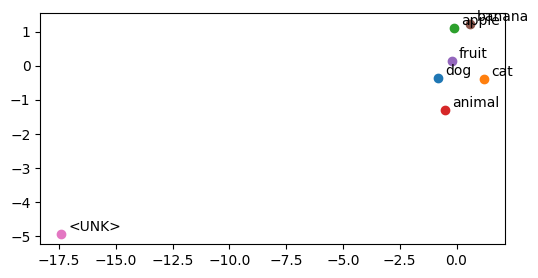

In [73]:
plt.figure(figsize=(6,3))
for i , word in enumerate(vocabs):
  x,y = get_embed(word)
  plt.scatter(x,y)
  plt.annotate(word, xy=(x,y), xytext=(5,2), textcoords='offset points')

plt.show()

#6. Cosine similarity

In [74]:
banana = get_embed('banana')
fruit = get_embed('fruit')

In [79]:
np.array(banana) @ np.array(fruit)

np.float64(0.05286360030136894)

In [80]:
unk = get_embed('<UNK>')

In [81]:
np.array(banana) @ np.array(unk)

np.float64(-16.11350406327074)